In [24]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline
# !pip install pennylane
import time
seconds = time.time()
print("Time in seconds since beginning of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since beginning of run: 1700553348.7650504
Tue Nov 21 07:55:48 2023


::: {#kernel_based_training}
:::

Kernel-based training of quantum models with scikit-learn
=========================================================

::: {.meta}
:property=\"og:description\": Train a quantum machine learning model
based on the idea of quantum kernels. :property=\"og:image\":
<https://pennylane.ai/qml/_images/kernel_based_scaling.png>
:::

::: {.related}
tutorial\_variational\_classifier Variational classifier
:::

*Author: Maria Schuld --- Posted: 03 February 2021. Last updated: 3
February 2021.*

Over the last few years, quantum machine learning research has provided
a lot of insights on how we can understand and train quantum circuits as
machine learning models. While many connections to neural networks have
been made, it becomes increasingly clear that their mathematical
foundation is intimately related to so-called *kernel methods*, the most
famous of which is the [support vector machine
(SVM)](https://en.wikipedia.org/wiki/Support-vector_machine) (see for
example [Schuld and Killoran (2018)](https://arxiv.org/abs/1803.07128),
[Havlicek et al. (2018)](https://arxiv.org/abs/1804.11326), [Liu et al.
(2020)](https://arxiv.org/abs/2010.02174), [Huang et al.
(2020)](https://arxiv.org/pdf/2011.01938), and, for a systematic summary
which we will follow here, [Schuld
(2021)](https://arxiv.org/abs/2101.11020)).

The link between quantum models and kernel methods has important
practical implications: we can replace the common [variational
approach](https://pennylane.ai/qml/glossary/variational_circuit.html) to
quantum machine learning with a classical kernel method where the
kernel---a small building block of the overall algorithm---is computed
by a quantum device. In many situations there are guarantees that we get
better or at least equally good results.

This demonstration explores how kernel-based training compares with
[variational
training](https://pennylane.ai/qml/demos/tutorial_variational_classifier.html)
in terms of the number of quantum circuits that have to be evaluated.
For this we train a quantum machine learning model with a kernel-based
approach using a combination of PennyLane and the
[scikit-learn](https://scikit-learn.org/) machine learning library. We
compare this strategy with a variational quantum circuit trained via
stochastic gradient descent using
[PyTorch](https://pennylane.readthedocs.io/en/stable/introduction/interfaces/torch.html).

We will see that in a typical small-scale example, kernel-based training
requires only a fraction of the number of quantum circuit evaluations
used by variational circuit training, while each evaluation runs a much
shorter circuit. In general, the relative efficiency of kernel-based
methods compared to variational circuits depends on the number of
parameters used in the variational model.

![](../demonstrations/kernel_based_training/scaling.png){.align-center}

If the number of variational parameters remains small, e.g., there is a
square-root-like scaling with the number of data samples (green line),
variational circuits are almost as efficient as neural networks (blue
line), and require much fewer circuit evaluations than the quadratic
scaling of kernel methods (red line). However, with current
hardware-compatible training strategies, kernel methods scale much
better than variational circuits that require a number of parameters of
the order of the training set size (orange line).

In conclusion, **for quantum machine learning applications with many
parameters, kernel-based training can be a great alternative to the
variational approach to quantum machine learning**.

After working through this demo, you will:

-   be able to use a support vector machine with a quantum kernel
    computed with PennyLane, and
-   be able to compare the scaling of quantum circuit evaluations
    required in kernel-based versus variational training.


Background
==========

Let us consider a *quantum model* of the form

$$f(x) = \langle \phi(x) | \mathcal{M} | \phi(x)\rangle,$$

where $| \phi(x)\rangle$ is prepared by a fixed [embedding
circuit](https://pennylane.ai/qml/glossary/quantum_embedding.html) that
encodes data inputs $x$, and $\mathcal{M}$ is an arbitrary observable.
This model includes variational quantum machine learning models, since
the observable can effectively be implemented by a simple measurement
that is preceded by a variational circuit:

![](../demonstrations/kernel_based_training/quantum_model.png){.align-center}

|

For example, applying a circuit $G(\theta)$ and then measuring the
Pauli-Z observable $\sigma^0_z$ of the first qubit implements the
trainable measurement
$\mathcal{M}(\theta) = G^{\dagger}(\theta) \sigma^0_z G(\theta)$.

The main practical consequence of approaching quantum machine learning
with a kernel approach is that instead of training $f$ variationally, we
can often train an equivalent classical kernel method with a kernel
executed on a quantum device. This *quantum kernel* is given by the
mutual overlap of two data-encoding quantum states,

$$\kappa(x, x') = | \langle \phi(x') | \phi(x)\rangle|^2.$$

Kernel-based training therefore bypasses the processing and measurement
parts of common variational circuits, and only depends on the data
encoding.

If the loss function $L$ is the [hinge
loss](https://en.wikipedia.org/wiki/Hinge_loss), the kernel method
corresponds to a standard [support vector
machine](https://en.wikipedia.org/wiki/Support-vector_machine) (SVM) in
the sense of a maximum-margin classifier. Other convex loss functions
lead to more general variations of support vector machines.

::: {.note}
::: {.title}
Note
:::

More precisely, we can replace variational with kernel-based training if
the optimisation problem can be written as minimizing a cost of the form

$$\min_f  \lambda\;  \mathrm{tr}\{\mathcal{M}^2\} + \frac{1}{M}\sum_{m=1}^M L(f(x^m), y^m),$$

which is a regularized empirical risk with training data samples
$(x^m, y^m)_{m=1\dots M}$, regularization strength
$\lambda \in \mathbb{R}$, and loss function $L$.

Theory predicts that kernel-based training will always find better or
equally good minima of this risk. However, to show this here we would
have to either regularize the variational training by the trace of the
squared observable, or switch off regularization in the classical SVM,
which removes a lot of its strength. The kernel-based and the
variational training in this demonstration therefore optimize slightly
different cost functions, and it is out of our scope to establish
whether one training method finds a better minimum than the other.
:::


Kernel-based training
=====================

First, we will turn to kernel-based training of quantum models. As
stated above, an example implementation is a standard support vector
machine with a kernel computed by a quantum circuit.


We begin by importing all sorts of useful methods:


In [25]:
import numpy as np
import torch
from torch.nn.functional import relu

from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pennylane as qml
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.operation import Tensor

import matplotlib.pyplot as plt

np.random.seed(42)

The second step is to define a data set. Since the performance of the
models is not the focus of this demo, we can just use the first two
classes of the famous [Iris data
set](https://en.wikipedia.org/wiki/Iris_flower_data_set). Dating back to
as far as 1936, this toy data set consists of 100 samples of four
features each, and gives rise to a very simple classification problem.


In [26]:
X, y = load_iris(return_X_y=True)

# pick inputs and labels from the first two classes only,
# corresponding to the first 100 samples
X = X[:100]
y = y[:100]

# scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# scaling the labels to -1, 1 is important for the SVM and the
# definition of a hinge loss
y_scaled = 2 * (y - 0.5)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled)

We use the [angle-embedding
template](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.templates.embeddings.AngleEmbedding.html)
which needs as many qubits as there are features:


In [27]:
n_qubits = len(X_train[0])
n_qubits

4

To implement the kernel we could prepare the two states
$| \phi(x) \rangle$, $| \phi(x') \rangle$ on different sets of qubits
with angle-embedding routines $S(x), S(x')$, and measure their overlap
with a small routine called a [SWAP
test](https://en.wikipedia.org/wiki/Swap_test).

However, we need only half the number of qubits if we prepare
$| \phi(x)\rangle$ and then apply the inverse embedding with $x'$ on the
same qubits. We then measure the projector onto the initial state
$|0..0\rangle \langle 0..0|$.

![](../demonstrations/kernel_based_training/kernel_circuit.png){.align-center}

To verify that this gives us the kernel:

$$\begin{aligned}
\begin{align*}
    \langle 0..0 |S(x') S(x)^{\dagger} \mathcal{M} S(x')^{\dagger} S(x)  | 0..0\rangle &= \langle 0..0 |S(x') S(x)^{\dagger} |0..0\rangle \langle 0..0| S(x')^{\dagger} S(x)  | 0..0\rangle  \\
    &= |\langle 0..0| S(x')^{\dagger} S(x)  | 0..0\rangle |^2\\
    &= | \langle \phi(x') | \phi(x)\rangle|^2 \\
    &= \kappa(x, x').
\end{align*}
\end{aligned}$$

Note that a projector $|0..0 \rangle \langle 0..0|$ can be constructed
using the `qml.Hermitian` observable in PennyLane.

Altogether, we use the following quantum node as a *quantum kernel
evaluator*:


In [28]:
dev_kernel = qml.device("lightning.qubit", wires=n_qubits)

projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel, interface="autograd")
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))

A good sanity check is whether evaluating the kernel of a data point and
itself returns 1:


In [29]:
kernel(X_train[0], X_train[0])

array(1.)

The way an SVM with a custom kernel is implemented in scikit-learn
requires us to pass a function that computes a matrix of kernel
evaluations for samples in two different datasets A, B. If A=B, this is
the [Gram matrix](https://en.wikipedia.org/wiki/Gramian_matrix).


In [30]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

Training the SVM optimizes internal parameters that basically weigh
kernel functions. It is a breeze in scikit-learn, which is designed as a
high-level machine learning library:


In [31]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

Let's compute the accuracy on the test set.


In [32]:
predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

1.0

The SVM predicted all test points correctly. How many times was the
quantum device evaluated?


In [33]:
dev_kernel.num_executions

7501

This number can be derived as follows: For $M$ training samples, the SVM
must construct the $M \times M$ dimensional kernel gram matrix for
training. To classify $M_{\rm pred}$ new samples, the SVM needs to
evaluate the kernel at most $M_{\rm pred}M$ times to get the pairwise
distances between training vectors and test samples.

::: {.note}
::: {.title}
Note
:::

Depending on the implementation of the SVM, only $S \leq M_{\rm pred}$
*support vectors* are needed.
:::

Let us formulate this as a function, which can be used at the end of the
demo to construct the scaling plot shown in the introduction.


In [34]:
def circuit_evals_kernel(n_data, split):
    """Compute how many circuit evaluations one needs for kernel-based
       training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = M * M
    n_prediction = M * Mpred

    return n_training + n_prediction

With $M = 75$ and $M_{\rm pred} = 25$, the number of kernel evaluations
can therefore be estimated as:


In [35]:
circuit_evals_kernel(n_data=len(X), split=len(X_train) /(len(X_train) + len(X_test)))

7500

The single additional evaluation can be attributed to evaluating the
kernel once above as a sanity check.


A similar example using variational training
============================================


Using the variational principle of training, we can propose an *ansatz*
for the variational circuit and train it directly. By increasing the
number of layers of the ansatz, its expressivity increases. Depending on
the ansatz, we may only search through a subspace of all measurements
for the best candidate.

Remember from above, the variational training does not optimize
*exactly* the same cost as the SVM, but we try to match them as closely
as possible. For this we use a bias term in the quantum model, and train
on the hinge loss.

We also explicitly use the
[parameter-shift](https://pennylane.ai/qml/glossary/parameter_shift.html)
differentiation method in the quantum node, since this is a method which
works on hardware as well. While `diff_method='backprop'` or
`diff_method='adjoint'` would reduce the number of circuit evaluations
significantly, they are based on tricks that are only suitable for
simulators, and can therefore not scale to more than a few dozen qubits.


In [36]:
dev_var = qml.device("lightning.qubit", wires=n_qubits)

@qml.qnode(dev_var, interface="torch", diff_method="parameter-shift")
def quantum_model(x, params):
    """A variational quantum model."""

    # embedding
    AngleEmbedding(x, wires=range(n_qubits))

    # trainable measurement
    StronglyEntanglingLayers(params, wires=range(n_qubits), imprimitive=qml.ops.CZ)
    return qml.expval(qml.PauliZ(0))

def quantum_model_plus_bias(x, params, bias):
    """Adding a bias."""
    return quantum_model(x, params) + bias

def hinge_loss(predictions, targets):
    """Implements the hinge loss."""
    all_ones = torch.ones_like(targets)
    hinge_loss = all_ones - predictions * targets
    # trick: since the max(0,x) function is not differentiable,
    # use the mathematically equivalent relu instead
    hinge_loss = relu(hinge_loss)
    return hinge_loss

We now summarize the usual training and prediction steps into two
functions similar to scikit-learn\'s `fit()` and `predict()`. While it
feels cumbersome compared to the one-liner used to train the kernel
method, PennyLane---like other differentiable programming
libraries---provides a lot more control over the particulars of
training.

In our case, most of the work is to convert between numpy and torch,
which we need for the differentiable `relu` function used in the hinge
loss.


In [37]:
def quantum_model_train(n_layers, steps, batch_size):
    """Train the quantum model defined above."""

    params = np.random.random((n_layers, n_qubits, 3))
    params_torch = torch.tensor(params, requires_grad=True)
    bias_torch = torch.tensor(0.0)

    opt = torch.optim.Adam([params_torch, bias_torch], lr=0.1)

    loss_history = []
    for i in range(steps):

        batch_ids = np.random.choice(len(X_train), batch_size)

        X_batch = X_train[batch_ids]
        y_batch = y_train[batch_ids]

        X_batch_torch = torch.tensor(X_batch, requires_grad=False)
        y_batch_torch = torch.tensor(y_batch, requires_grad=False)

        def closure():
            opt.zero_grad()
            preds = torch.stack(
                [quantum_model_plus_bias(x, params_torch, bias_torch) for x in X_batch_torch]
            )
            loss = torch.mean(hinge_loss(preds, y_batch_torch))

            # bookkeeping
            current_loss = loss.detach().numpy().item()
            loss_history.append(current_loss)
            if i % 10 == 0:
                print("step", i, ", loss", current_loss)

            loss.backward()
            return loss

        opt.step(closure)

    return params_torch, bias_torch, loss_history


def quantum_model_predict(X_pred, trained_params, trained_bias):
    """Predict using the quantum model defined above."""

    p = []
    for x in X_pred:

        x_torch = torch.tensor(x)
        pred_torch = quantum_model_plus_bias(x_torch, trained_params, trained_bias)
        pred = pred_torch.detach().numpy().item()
        if pred > 0:
            pred = 1
        else:
            pred = -1

        p.append(pred)
    return p

Let's train the variational model and see how well we are doing on the
test set.


step 0 , loss 1.3954538582486848
step 10 , loss 1.0327197958428413
step 20 , loss 0.7384115263490277
step 30 , loss 0.6520626179157314
step 40 , loss 0.23666090760002514
step 50 , loss 0.5875523002081291
step 60 , loss 0.2570026003906574
step 70 , loss 0.35849991622711386
step 80 , loss 0.5062554348569632
step 90 , loss 0.40632180996652634
accuracy on test set: 0.96


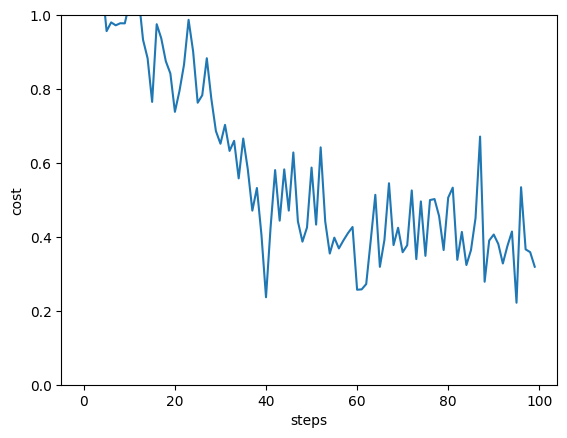

In [38]:
n_layers = 2
batch_size = 20
steps = 100
trained_params, trained_bias, loss_history = quantum_model_train(n_layers, steps, batch_size)

pred_test = quantum_model_predict(X_test, trained_params, trained_bias)
print("accuracy on test set:", accuracy_score(pred_test, y_test))

plt.plot(loss_history)
plt.ylim((0, 1))
plt.xlabel("steps")
plt.ylabel("cost")
plt.show()

The variational circuit has a slightly lower accuracy than the SVM---but
this depends very much on the training settings we used. Different
random parameter initializations, more layers, or more steps may indeed
get perfect test accuracy.

How often was the device executed?


In [39]:
dev_var.num_executions

74025

That is a lot more than the kernel method took!

Let's try to understand this value. In each optimization step, the
variational circuit needs to compute the partial derivative of all
trainable parameters for each sample in a batch. Using parameter-shift
rules, we require roughly two circuit evaluations per partial
derivative. Prediction uses only one circuit evaluation per sample.

We can formulate this as another function that will be used in the
scaling plot below.


In [40]:
def circuit_evals_variational(n_data, n_params, n_steps, shift_terms, split, batch_size):
    """Compute how many circuit evaluations are needed for
       variational training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_params * n_steps * batch_size * shift_terms
    n_prediction = Mpred

    return n_training + n_prediction

This estimates the circuit evaluations in variational training as:


In [41]:
circuit_evals_variational(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    shift_terms=2,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

96025

The estimate is a bit higher because it does not account for some
optimizations that PennyLane performs under the hood.

It is important to note that while they are trained in a similar manner,
the number of variational circuit evaluations differs from the number of
neural network model evaluations in classical machine learning, which
would be given by:


In [42]:
def model_evals_nn(n_data, n_params, n_steps, split, batch_size):
    """Compute how many model evaluations are needed for neural
       network training and prediction."""

    M = int(np.ceil(split * n_data))
    Mpred = n_data - M

    n_training = n_steps * batch_size
    n_prediction = Mpred

    return n_training + n_prediction

In each step of neural network training, and due to the clever
implementations of automatic differentiation, the backpropagation
algorithm can compute a gradient for all parameters in (more-or-less) a
single run. For all we know at this stage, the no-cloning principle
prevents variational circuits from using these tricks, which leads to
`n_training` in `circuit_evals_variational` depending on the number of
parameters, but not in `model_evals_nn`.

For the same example as used here, a neural network would therefore have
far fewer model evaluations than both variational and kernel-based
training:


In [43]:
model_evals_nn(
    n_data=len(X),
    n_params=len(trained_params.flatten()),
    n_steps=steps,
    split=len(X_train) /(len(X_train) + len(X_test)),
    batch_size=batch_size,
)

2025

Which method scales best?
=========================


The answer to this question depends on how the variational model is set
up, and we need to make a few assumptions:

1.  Even if we use single-batch stochastic gradient descent, in which
    every training step uses exactly one training sample, we would want
    to see every training sample at least once on average. Therefore,
    the number of steps should scale at least linearly with the number
    of training data samples.

2.  Modern neural networks often have many more parameters than training
    samples. But we do not know yet whether variational circuits really
    need that many parameters as well. We will therefore use two cases
    for comparison:

    2a) the number of parameters grows linearly with the training data,
    or `n_params = M`,

    2b) the number of parameters saturates at some point, which we model
    by setting `n_params = sqrt(M)`.

Note that compared to the example above with 75 training samples and 24
parameters, a) overestimates the number of evaluations, while b)
underestimates it.


This is how the three methods compare:


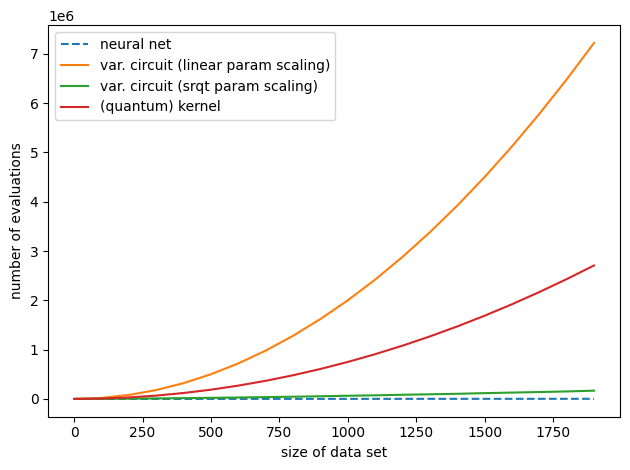

In [44]:
variational_training1 = []
variational_training2 = []
kernelbased_training = []
nn_training = []
x_axis = range(0, 2000, 100)

for M in x_axis:

    var1 = circuit_evals_variational(
        n_data=M, n_params=M, n_steps=M,  shift_terms=2, split=0.75, batch_size=1
    )
    variational_training1.append(var1)

    var2 = circuit_evals_variational(
        n_data=M, n_params=round(np.sqrt(M)), n_steps=M,
        shift_terms=2, split=0.75, batch_size=1
    )
    variational_training2.append(var2)

    kernel = circuit_evals_kernel(n_data=M, split=0.75)
    kernelbased_training.append(kernel)

    nn = model_evals_nn(
        n_data=M, n_params=M, n_steps=M, split=0.75, batch_size=1
    )
    nn_training.append(nn)


plt.plot(x_axis, nn_training, linestyle='--', label="neural net")
plt.plot(x_axis, variational_training1, label="var. circuit (linear param scaling)")
plt.plot(x_axis, variational_training2, label="var. circuit (srqt param scaling)")
plt.plot(x_axis, kernelbased_training, label="(quantum) kernel")
plt.xlabel("size of data set")
plt.ylabel("number of evaluations")
plt.legend()
plt.tight_layout()
plt.show()

This is the plot we saw at the beginning. With current
hardware-compatible training methods, whether kernel-based training
requires more or fewer quantum circuit evaluations than variational
training depends on how many parameters the latter needs. If variational
circuits turn out to be as parameter-hungry as neural networks,
kernel-based training will outperform them for common machine learning
tasks. However, if variational learning only turns out to require few
parameters (or if more efficient training methods are found),
variational circuits could in principle match the linear scaling of
neural networks trained with backpropagation.

The practical take-away from this demo is that unless your variational
circuit has significantly fewer parameters than training data, kernel
methods could be a much faster alternative!

Finally, it is important to note that fault-tolerant quantum computers
may change the picture for both quantum and classical machine learning.
As mentioned in [Schuld (2021)](https://arxiv.org/abs/2101.11020), early
results from the quantum machine learning literature show that larger
quantum computers will most likely enable us to reduce the quadratic
scaling of kernel methods to linear scaling, which may make classical as
well as quantum kernel methods a strong alternative to neural networks
for big data processing one day.


About the author
================


In [45]:
seconds = time.time()
print("Time in seconds since end of run:", seconds)
local_time = time.ctime(seconds)
print(local_time)

Time in seconds since end of run: 1700553716.0580668
Tue Nov 21 08:01:56 2023
